In [ ]:
# %%

" ai for source separation of percussions in urban sounds"
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os
import time
import soundfile as sf
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tqdm import tqdm
import random
import argparse
import pandas as pd
from tqdm import tqdm
# We have 7358 sounds of differents classes (dog bark, drilling, jackhammer, siren, children_playing, engine idling, air conditioner, car horn) with a duration of maximum 4 seconds some are shorter
# 387 files of the percussions class that we want to separate from the others or "hear" better

n_fft = 256
hop_length = n_fft // 4

In [ ]:
# %%

# where to find the noise
DATASET_NOISE_PATH = "C:\\Users\\jejep\\Desktop\\STAGE\\dataset"

metadata_noise = os.path.join(DATASET_NOISE_PATH, "UrbanSound8k.csv")
metadata_noise = pd.read_csv(metadata_noise)
print(metadata_noise['class'].value_counts())

# class
# dog_bark            1000
# children_playing    1000
# air_conditioner     1000
# engine_idling       1000
# jackhammer          1000
# drilling            1000
# siren                929
# car_horn             429
# Name: count, dtype: int64

DATASET_PERCUSSION_PATH = "C:\\Users\\jejep\\Desktop\\STAGE\\J.Palmilha\\data"
metadata_perc = os.path.join(DATASET_PERCUSSION_PATH, "metadata.csv")
metadata_perc = pd.read_csv(metadata_perc)

metadata_perc.value_counts()

# Example dataframe for noise classes
noise_data = {
    'class': ['dog_bark', 'children_playing', 'air_conditioner', 'engine_idling',
              'jackhammer', 'drilling', 'siren', 'car_horn'],
    'count': [1000, 1000, 1000, 1000, 1000, 1000, 929, 429]
}
df = pd.DataFrame(noise_data)

# Example paths to noise files (adjust paths according to your setup)
noise_folder = DATASET_NOISE_PATH  # path to the folder containing the noise files

class
dog_bark            1000
children_playing    1000
air_conditioner     1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
Name: count, dtype: int64


In [ ]:
# %%

# Function to create mixture


def create_mixture(percussion_audio, noise_audio):

    percussion_audio /= np.max(np.abs(percussion_audio))
    noise_audio /= np.max(np.abs(noise_audio))

    # Mix audio files
    mixture_audio = percussion_audio + noise_audio

    # Normalize mixture
    mixture_audio /= np.max(np.abs(mixture_audio))

    # Calculate stft
    stft = librosa.stft(mixture_audio, n_fft=n_fft, hop_length=hop_length)

    return mixture_audio, stft


def get_stft(audio):

    # Normalize audio
    audio /= np.max(np.abs(audio))

    # Calculate stft
    stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)

    return stft


def audio_from_spectrogram(mag, phase):
    stft = mag * np.exp(1j*phase)
    # audio = librosa.istft(stft, hop_length=hop_length)
    stft = torch.tensor(stft, dtype=torch.complex64, requires_grad=True)
    audio = torch.istft(stft, n_fft=n_fft, hop_length=hop_length,
                        length=4 * 7812, window=torch.hann_window(n_fft, device='cpu'))
    return audio

# calculate error reconstruction and original


def calculate_error(original, reconstruction):
    error = torch.abs(original - reconstruction).mean()  # mean absolute
    return error

In [ ]:
# %%

# Total number of percussion files
percussion_count = 387

# Calculate total number of noise files
total_noise_files = df['count'].sum()

# Calculate proportions for each noise class
df['proportion'] = df['count'] / total_noise_files

# every percussion files will get 40 noise files 5 from each class
# this will give us a total number of 387 * 24 = 9288 noise files
# Number of noise files to select for each percussion file
noise_files_per_percussion = 40

# we will save the informations of all the noised used for each percussion file
# save the informations in a csv file : percussion_file, noise_file, noise_class, mixture_file


def pad_audio_center(audio_path):

    # Load audio files
    audio, _ = librosa.load(path=audio_path, sr=7812)

    # Pad audio to have length of 4 seconds
    audio_len = len(audio)
    target_len = 4 * 7812  # 4 seconds at 7812 Hz
    pad_len = target_len - audio_len

    if pad_len > 0:
        pad_left = pad_len // 2
        pad_right = pad_len - pad_left
        audio = np.pad(audio, (pad_left, pad_right), 'constant')
    else:
        audio = audio[:target_len]

    return audio

In [ ]:
# %%

# Create a folder to save mixture audio
DATASET_MIX_AUDIO_PATH = "C:\\Users\\jejep\\Desktop\\STAGE\\data\\mixture_audio"

# Create the folder if it does not exist
if not os.path.exists(DATASET_MIX_AUDIO_PATH):
    os.makedirs(DATASET_MIX_AUDIO_PATH)

DATASET_MIX_STFT_PATH = "C:\\Users\\jejep\\Desktop\\STAGE\\data\\mixture_stft"

# Create the folder if it does not exist
if not os.path.exists(DATASET_MIX_STFT_PATH):
    os.makedirs(DATASET_MIX_STFT_PATH)

# Create a folder to save percussion stft
DATASET_PERCUSSION_STFT_PATH = "C:\\Users\\jejep\\Desktop\\STAGE\\data\\percussion_stft"

# Create the folder if it does not exist
if not os.path.exists(DATASET_PERCUSSION_STFT_PATH):
    os.makedirs(DATASET_PERCUSSION_STFT_PATH)

# Create a folder to save noise stft
DATASET_NOISE_STFT_PATH = "C:\\Users\\jejep\\Desktop\\STAGE\\data\\noise_stft"

# Create the folder if it does not exist
if not os.path.exists(DATASET_NOISE_STFT_PATH):
    os.makedirs(DATASET_NOISE_STFT_PATH)

In [ ]:
# %%

# Iterate over each percussion file
for index, row in metadata_perc.iterrows():
    percussion_filename = row['name']
    percussion_file = os.path.join(
        DATASET_PERCUSSION_PATH, percussion_filename)

    # Create a list to store noise information
    sound_info = []

    # Iterate over each noise class
    for _, noise_row in df.iterrows():
        noise_class = noise_row['class']
        noise_count = noise_row['count']
        noise_proportion = noise_row['proportion']

        # Calculate number of noise files to select for this class
        noise_files_to_select = int(
            noise_files_per_percussion * noise_proportion)

        # Randomly select noise files from the current class
        selected_fold = np.random.randint(1, 11)
        noise_files_in_fold = metadata_noise[(metadata_noise['class'] == noise_class) &
                                             (metadata_noise['fold'] == selected_fold)]['slice_file_name'].tolist()

        if len(noise_files_in_fold) > 0:
            selected_noise_files = np.random.choice(
                noise_files_in_fold, noise_files_to_select, replace=False)

            for noise_file_name in selected_noise_files:
                noise_file = os.path.join(DATASET_NOISE_PATH, f"fold{
                                          selected_fold}", noise_file_name)

                # Load audio files
                percussion_audio = pad_audio_center(percussion_file)
                noise_audio = pad_audio_center(noise_file)

                # Calculate stft
                stft_p = get_stft(percussion_audio)
                stft_n = get_stft(noise_audio)

                # create mixture
                mixture_audio, stft_mix = create_mixture(
                    percussion_audio, noise_audio)

                # Save sound information
                sound_info.append({
                    'percussion_file': percussion_filename,
                    'noise_file': noise_file_name,
                    # mixture file name
                    'mix_file': f"{percussion_filename}_{noise_file_name}",
                    'noise_class': noise_class,
                    'fold': selected_fold,
                })

                # Save mixture audio
                mixture_audio_path = os.path.join(
                    DATASET_MIX_AUDIO_PATH, f"{percussion_filename}_{noise_file_name}.wav")
                sf.write(mixture_audio_path, mixture_audio, 7812)

                # Save mixture stft
                mix_stft_path = os.path.join(
                    DATASET_MIX_STFT_PATH, f"{percussion_filename}_{noise_file_name}.npy")
                np.save(mix_stft_path, stft_mix)

                # Save noise stft
                noise_stft_path = os.path.join(
                    DATASET_NOISE_STFT_PATH, f"{noise_file_name}.npy")
                np.save(noise_stft_path, stft_n)

                # Save percussion stft
                percussion_stft_path = os.path.join(
                    DATASET_PERCUSSION_STFT_PATH, f"{percussion_filename}.npy")
                np.save(percussion_stft_path, stft_p)

    # Save sound information to a csv file
    sound_info = pd.DataFrame(sound_info)
    sound_info.to_csv(os.path.join(
        DATASET_MIX_AUDIO_PATH, f"{percussion_filename}_info.csv"), index=False)

In [ ]:
# %%

# We have the 387 metadata files (same number of percussion)

# we should save the metadata into a single metadata file
# we can use this metadata file to load the data into the dataset class
# we can also use it to split the data into training, validation and test sets
# we can also use it to load only the noise files of a specific class

metadata_info = []

for index, row in metadata_perc.iterrows():
    percussion_filename = row['name']
    sound_info = pd.read_csv(os.path.join(
        DATASET_MIX_AUDIO_PATH, f"{percussion_filename}_info.csv"))
    metadata_info.append(sound_info)

metadata_info=pd.concat(metadata_info)
metadata_info.to_csv(os.path.join(
    DATASET_MIX_AUDIO_PATH, "metadata.csv"), index=False)

In [ ]:
# %%

# Define the dataset class


class MixtureDataset(Dataset):
    # noise class is a string maybe
    def __init__(self, metadata_file, transform=None, noise_class=None):
        self.metadata = metadata_file
        # since we have multiple classes of noise we can choose one to train the model... we can also train the model with all the classes
        # we can use it to load only the noise files of a specific class
        self.noise_class = noise_class
        self.transform = transform

    def __len__(self):
        # get the row with only the noise class we want
        if self.noise_class:
            return len(self.metadata[self.metadata['noise_class'] == self.noise_class])

    def __getitem__(self, idx):
        # get the row with only the noise class we want
        if self.noise_class:
            row = self.metadata[self.metadata['noise_class']
                                == self.noise_class].iloc[idx]

            # Load mixture stft
            mixture_stft = np.load(os.path.join(
                DATASET_MIX_STFT_PATH, f"{row['mix_file']}.npy"))
            mixture_stft = torch.tensor(
                mixture_stft, requires_grad=True, dtype=torch.complex64, device='cuda')

            # Load noise stft
            noise_stft = np.load(os.path.join(
                DATASET_NOISE_STFT_PATH, f"{row['noise_file']}.npy"))
            noise_stft = torch.tensor(
                noise_stft, requires_grad=True, dtype=torch.complex64, device='cuda')

            # Load percussion stft
            percussion_stft = np.load(os.path.join(
                DATASET_PERCUSSION_STFT_PATH, f"{row['percussion_file']}.npy"))
            percussion_stft = torch.tensor(
                percussion_stft, requires_grad=True, dtype=torch.complex64, device='cuda')

            # Apply transform if it exists
            if self.transform:
                mixture_stft, noise_stft, percussion_stft = self.transform(
                    mixture_stft, noise_stft, percussion_stft)

            return {
                'mixture_stft': mixture_stft,
                'noise_stft': noise_stft,
                'percussion_stft': percussion_stft
            }

In [ ]:
# %%

# Load metadata
metadata = pd.read_csv(os.path.join(
    DATASET_MIX_AUDIO_PATH, "metadata.csv"))

# define the train, validation and test sets

dataset = MixtureDataset(metadata_file=metadata, noise_class='dog_bark')

# Split the dataset into training, validation and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# %%

# test the dataloader
data = next(iter(train_loader))
print(data.keys())

for keys in data.keys():
    print(keys, data[keys].shape)

print(data['mixture_stft'])

dict_keys(['mixture_stft', 'noise_stft', 'percussion_stft'])
mixture_stft torch.Size([16, 129, 489])
noise_stft torch.Size([16, 129, 489])
percussion_stft torch.Size([16, 129, 489])
tensor([[[ 7.9768e+00+0.0000e+00j,  1.6184e+01+0.0000e+00j,
           2.0808e+01+0.0000e+00j,  ...,
           1.8088e+01+0.0000e+00j,  1.7845e+01+0.0000e+00j,
           1.3357e+01+0.0000e+00j],
         [-3.6607e+00+5.2611e+00j, -9.0840e+00+2.6953e+00j,
          -1.0535e+01+1.6777e+00j,  ...,
          -8.4375e+00-1.7285e+00j, -9.3128e+00+1.6723e+00j,
          -8.7636e+00-5.9091e+00j],
         [-4.4813e-01-3.2080e+00j,  5.9872e-01+4.3379e-01j,
           6.9319e-02-4.2319e-01j,  ...,
          -7.7657e-01+2.4048e+00j, -2.0140e-01-2.9390e+00j,
           3.2702e+00+4.2065e+00j],
         ...,
         [ 7.1903e-02-3.8623e-02j, -5.0149e-02+2.6814e-02j,
           1.1412e-02+1.8182e-02j,  ...,
           7.0321e-03+4.1344e-02j,  8.7580e-03+1.5134e-02j,
          -4.6344e-02-6.6166e-02j],
         [-4.508

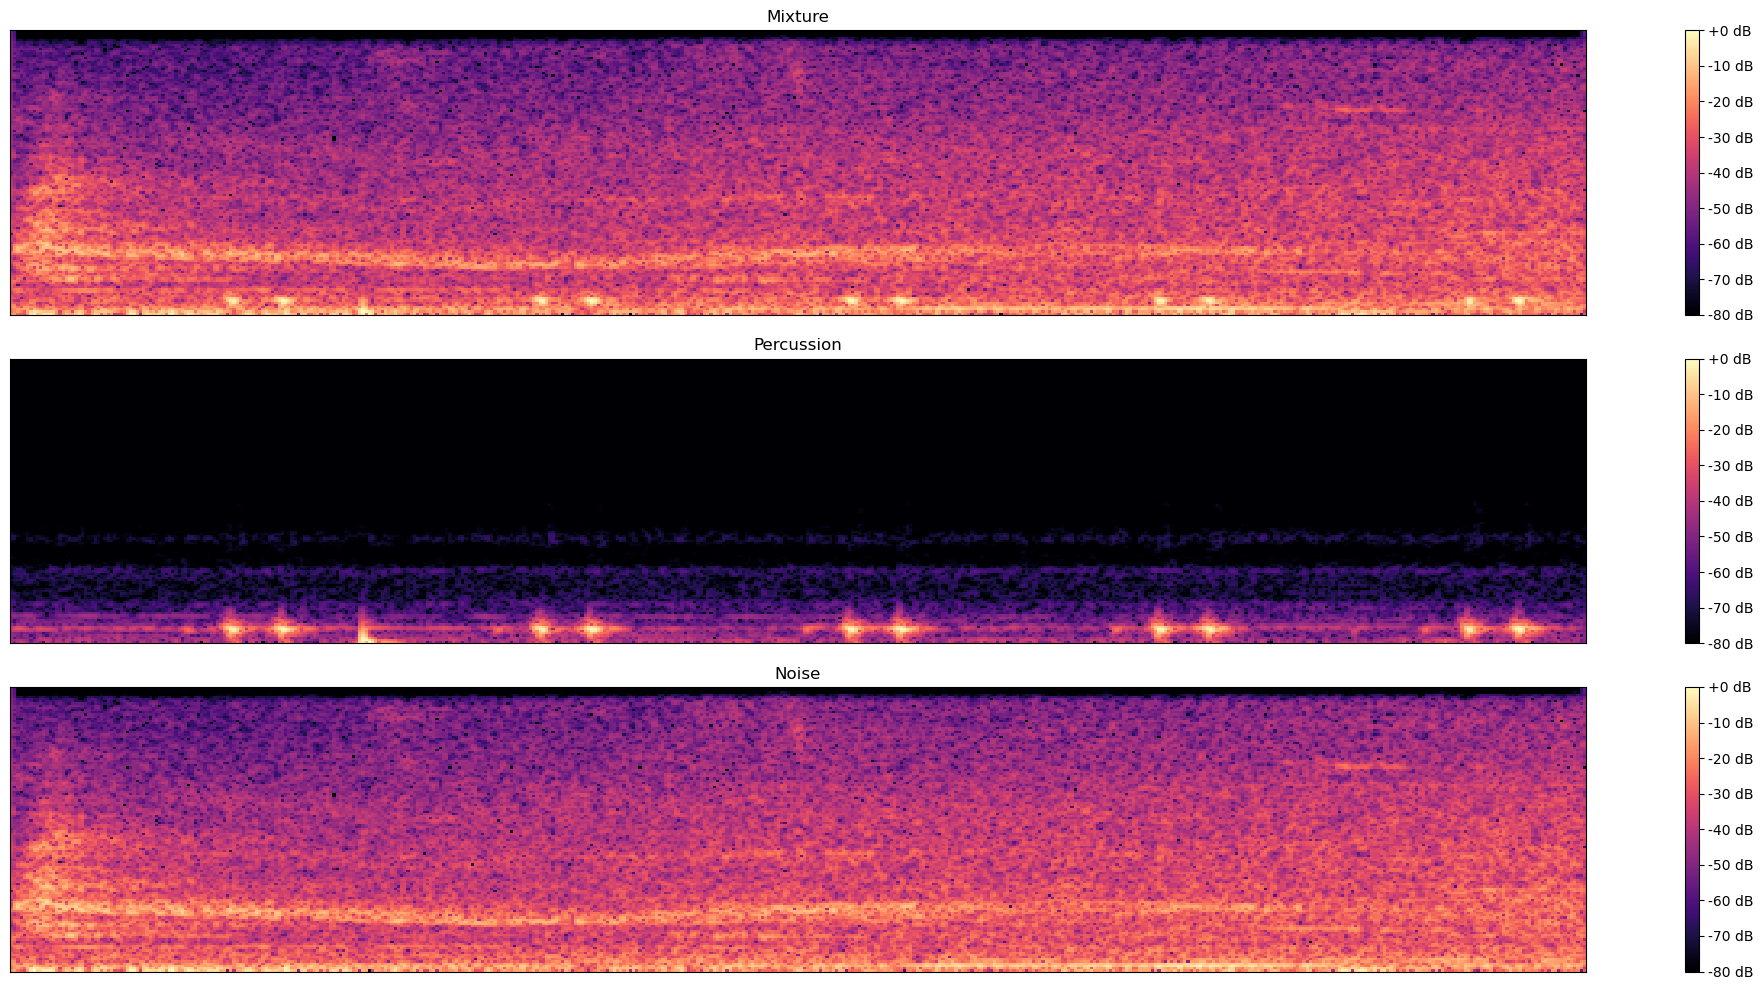

In [ ]:
# %%

# randomly select an index
i = random.randint(0, len(data['mixture_stft']) - 1)

# plot the mixture, percussion
mixture_stft = data['mixture_stft'][i]
percussion_stft = data['percussion_stft'][i]
noise_stft = data['noise_stft'][i]

# Convert the mixture to numpy
mixture_stft = mixture_stft.cpu().detach().numpy()

# Convert the target to numpy
percussion_stft = percussion_stft.cpu().detach().numpy()

# Convert the noise to numpy
noise_stft = noise_stft.cpu().detach().numpy()

# Plot the mixture and percussion stft
plt.figure(figsize=(20, 10))
plt.subplot(3, 1, 1)
plt.title("Mixture")
librosa.display.specshow(librosa.amplitude_to_db(
    np.abs(mixture_stft), ref=np.max), sr=7812, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')

plt.subplot(3, 1, 2)
plt.title("Percussion")
librosa.display.specshow(librosa.amplitude_to_db(
    np.abs(percussion_stft), ref=np.max), sr=7812, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')

plt.subplot(3, 1, 3)
plt.title("Noise")
librosa.display.specshow(librosa.amplitude_to_db(
    np.abs(noise_stft), ref=np.max), sr=7812, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

In [ ]:
# %%

# Load metadata
metadata = pd.read_csv(os.path.join(
    DATASET_MIX_AUDIO_PATH, "metadata.csv"))

# define the train, validation and test sets

dataset = MixtureDataset(metadata_file=metadata, noise_class='jackhammer')

# Split the dataset into training, validation and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# %%

# test the dataloader
data = next(iter(train_loader))
print(data.keys())

for keys in data.keys():
    print(keys, data[keys].shape)

print(data['mixture_stft'])

dict_keys(['mixture_stft', 'noise_stft', 'percussion_stft'])
mixture_stft torch.Size([16, 129, 489])
noise_stft torch.Size([16, 129, 489])
percussion_stft torch.Size([16, 129, 489])
tensor([[[-6.7940e-01+0.0000e+00j, -1.6422e-01+0.0000e+00j,
          -3.5106e-01+0.0000e+00j,  ...,
          -7.1362e+00+0.0000e+00j, -9.2404e+00+0.0000e+00j,
          -8.1890e+00+0.0000e+00j],
         [ 7.9023e-01-5.0192e-02j, -1.7921e-01+6.0949e-01j,
          -7.1065e-02-8.0033e-01j,  ...,
           3.6918e+00-6.8423e-01j,  4.4857e+00-1.4660e+00j,
           5.9936e+00+2.4548e+00j],
         [-9.8553e-01+3.8912e-01j,  5.3830e-01-7.5197e-02j,
           8.2234e-01+3.5706e-01j,  ...,
           2.7440e-03-6.3188e-02j,  1.0729e+00+3.8760e-01j,
          -3.6549e+00-1.3389e+00j],
         ...,
         [ 1.0167e-01-2.1644e-03j, -4.9968e-02+1.4455e-03j,
          -2.3511e-03+4.9305e-03j,  ...,
          -5.5149e-04-1.5047e-02j, -3.3176e-02-4.4274e-02j,
           1.2491e-01+1.0144e-01j],
         [-9.305

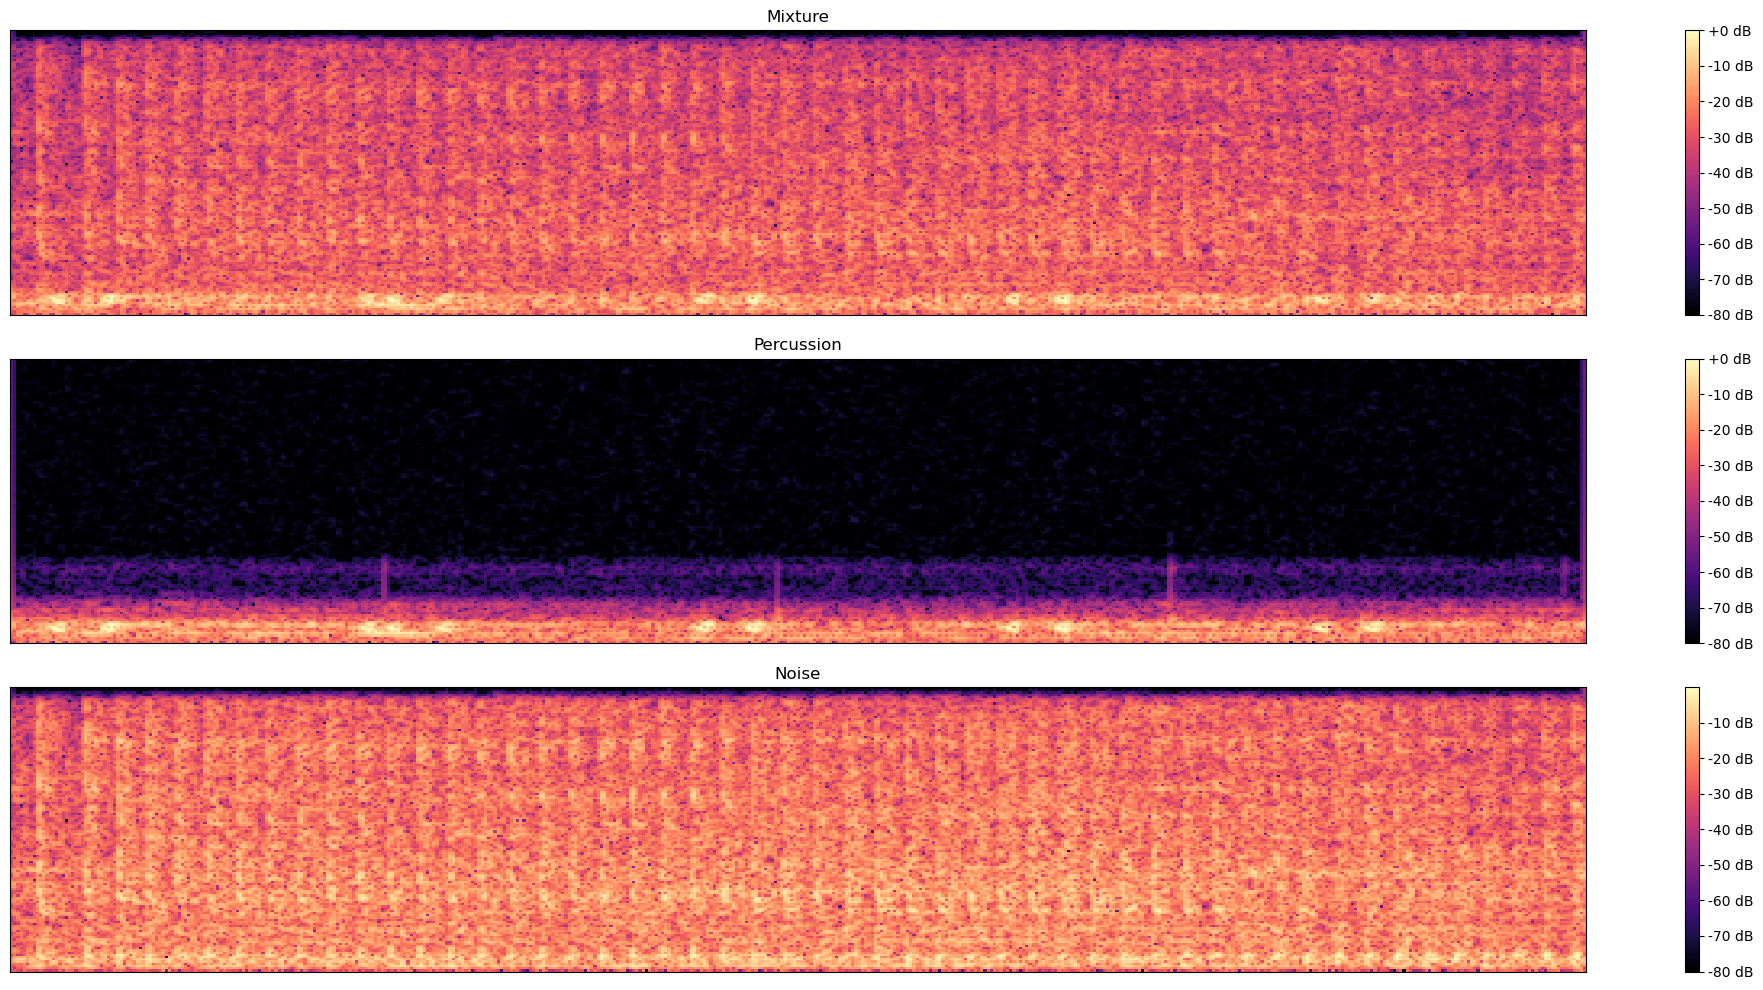

In [ ]:
# %%

# randomly select an index
i = random.randint(0, len(data['mixture_stft']) - 1)

# plot the mixture, percussion
mixture_stft = data['mixture_stft'][i]
percussion_stft = data['percussion_stft'][i]
noise_stft = data['noise_stft'][i]

# Convert the mixture to numpy
mixture_stft = mixture_stft.cpu().detach().numpy()

# Convert the target to numpy
percussion_stft = percussion_stft.cpu().detach().numpy()

# Convert the noise to numpy
noise_stft = noise_stft.cpu().detach().numpy()

# Plot the mixture and percussion stft
plt.figure(figsize=(20, 10))
plt.subplot(3, 1, 1)
plt.title("Mixture")
librosa.display.specshow(librosa.amplitude_to_db(
    np.abs(mixture_stft), ref=np.max), sr=7812, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')

plt.subplot(3, 1, 2)
plt.title("Percussion")
librosa.display.specshow(librosa.amplitude_to_db(
    np.abs(percussion_stft), ref=np.max), sr=7812, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')

plt.subplot(3, 1, 3)
plt.title("Noise")
librosa.display.specshow(librosa.amplitude_to_db(
    np.abs(noise_stft), ref=np.max), sr=7812, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

In [ ]:
# %%

# Load metadata
metadata = pd.read_csv(os.path.join(
    DATASET_MIX_AUDIO_PATH, "metadata.csv"))

# define the train, validation and test sets

dataset = MixtureDataset(metadata_file=metadata, noise_class='dog_bark')

# Split the dataset into training, validation and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# %%

# test the dataloader
data = next(iter(train_loader))
print(data.keys())

for keys in data.keys():
    print(keys, data[keys].shape)

print(data['mixture_stft'])

dict_keys(['mixture_stft', 'noise_stft', 'percussion_stft'])
mixture_stft torch.Size([16, 129, 489])
noise_stft torch.Size([16, 129, 489])
percussion_stft torch.Size([16, 129, 489])
tensor([[[ 6.2585e+00+0.0000e+00j,  9.9504e+00+0.0000e+00j,
           1.0810e+01+0.0000e+00j,  ...,
           1.0199e+01+0.0000e+00j,  1.0679e+01+0.0000e+00j,
           6.4976e+00+0.0000e+00j],
         [-3.6966e+00+3.5462e+00j, -5.4647e+00+7.8041e-03j,
          -5.3402e+00+7.3207e-01j,  ...,
          -4.5633e+00+6.3564e-01j, -6.6692e+00-3.6085e-02j,
          -3.4612e+00-4.0401e+00j],
         [ 8.8974e-01-2.7703e+00j, -4.4297e-02+1.3534e+00j,
          -5.6840e-02-8.1750e-01j,  ...,
          -9.5612e-01-4.8742e-01j,  9.8128e-01-7.4363e-01j,
           3.5321e-01+2.8410e+00j],
         ...,
         [ 2.9835e-02+7.9686e-04j, -7.6011e-03-1.1806e-02j,
          -1.1041e-02+2.2953e-02j,  ...,
          -1.6086e-02-7.2734e-03j, -5.1259e-04-7.4981e-03j,
           2.3132e-02+2.3166e-02j],
         [-3.124

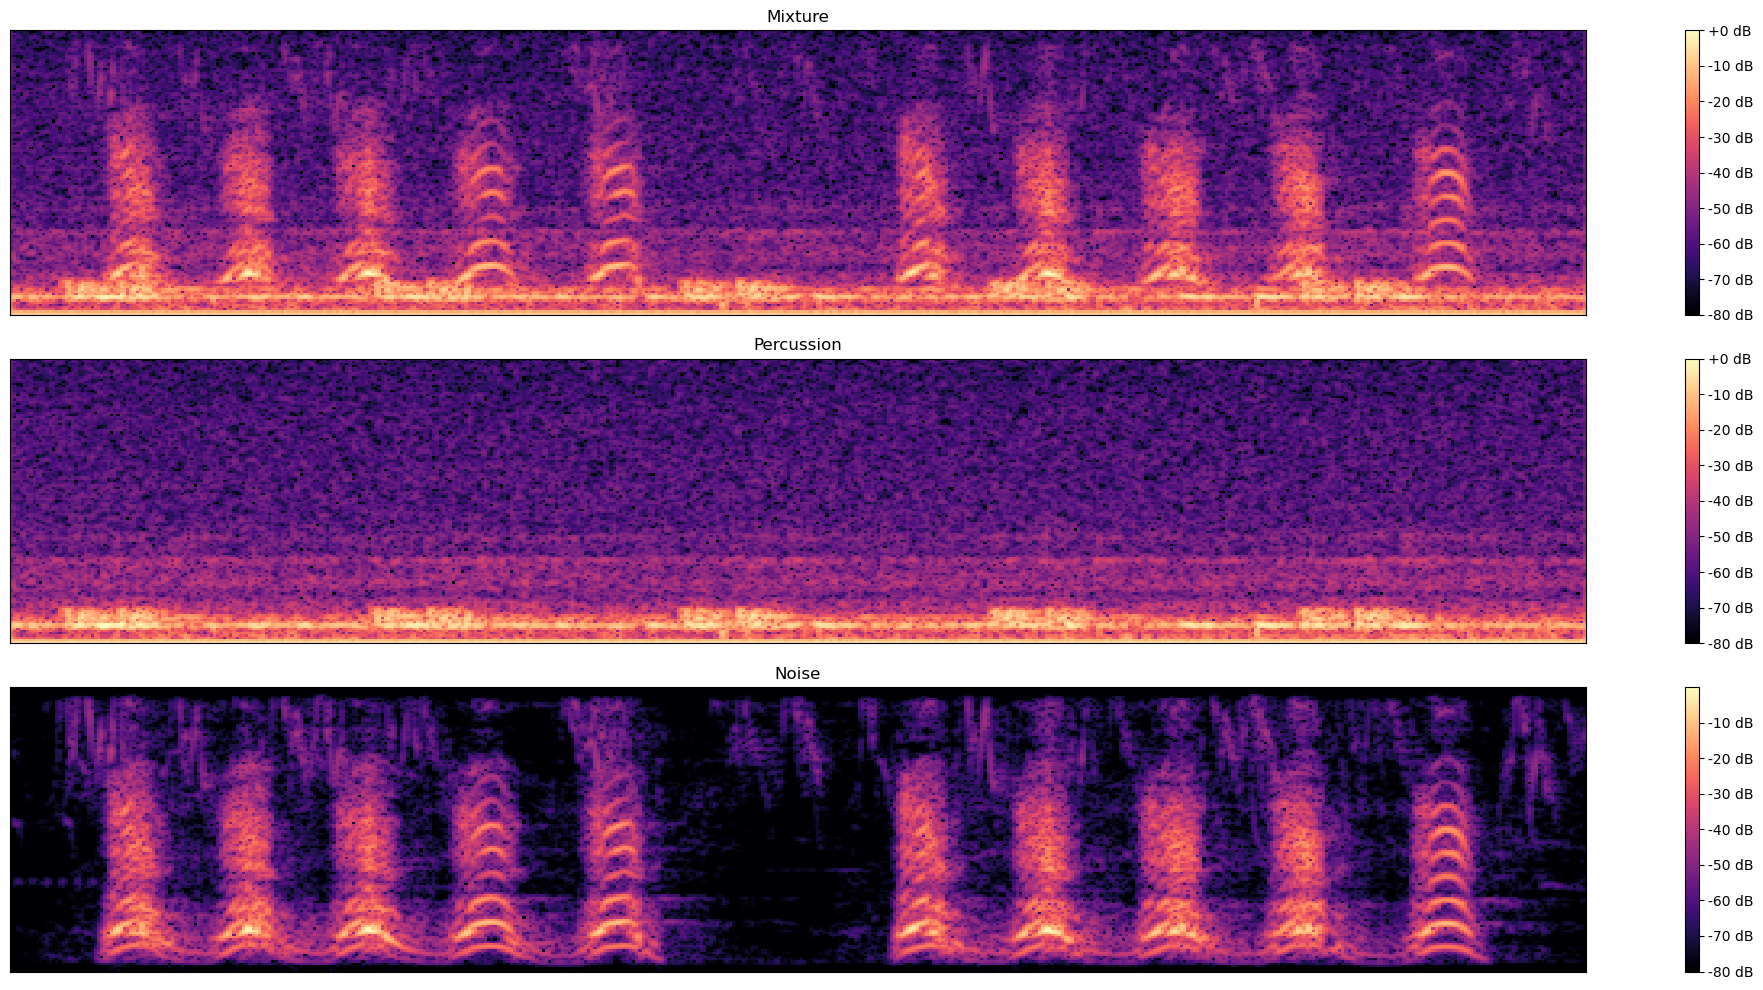

In [ ]:
# %%

# randomly select an index
i = random.randint(0, len(data['mixture_stft']) - 1)

# plot the mixture, percussion
mixture_stft = data['mixture_stft'][i]
percussion_stft = data['percussion_stft'][i]
noise_stft = data['noise_stft'][i]

# Convert the mixture to numpy
mixture_stft = mixture_stft.cpu().detach().numpy()

# Convert the target to numpy
percussion_stft = percussion_stft.cpu().detach().numpy()

# Convert the noise to numpy
noise_stft = noise_stft.cpu().detach().numpy()

# Plot the mixture and percussion stft
plt.figure(figsize=(20, 10))
plt.subplot(3, 1, 1)
plt.title("Mixture")
librosa.display.specshow(librosa.amplitude_to_db(
    np.abs(mixture_stft), ref=np.max), sr=7812, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')

plt.subplot(3, 1, 2)
plt.title("Percussion")
librosa.display.specshow(librosa.amplitude_to_db(
    np.abs(percussion_stft), ref=np.max), sr=7812, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')

plt.subplot(3, 1, 3)
plt.title("Noise")
librosa.display.specshow(librosa.amplitude_to_db(
    np.abs(noise_stft), ref=np.max), sr=7812, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

In [ ]:
# %%

# Define the model

# Evaluation metrics will be : signal-to-distortion ratio improvement SDRi and signal-to-distortion ratio improvement.


class SeparationModel(nn.Module):
    def __init__(self):
        super(SeparationModel, self).__init__()
        """
        Define the model architecture
            It's a resunet model
            The input will be the mixture stft the encoder decoder will process the magnitude spectrogram
            3 encoder blocks 2 bottleneck blocks and 3 decoder blocks.

            In each encoder block, the spectrogram is downsampled into a bottleneck feature using 4 residual convolutional blocks,
            while each decoder block utilizes 4 residual deconvolutional blocks to upsample the feature and obtain the separation components.
            A skip connection is established between each encoder block and the corresponding decoder block, operating at the same downsampling/upsampling rate.
            The residual block consists of 2 CNN layers, 2 batch normalization layers, and 2 Leaky-ReLU activation layers.
            Furthermore, we introduce an additional residual shortcut connecting the input and output of each residual block.
            The ResUNet model inputs the complex spectrogram X and outputs the magnitude mask |M| and the phase residual ∠M conditioned on the text embedding eq.
            |M| controls how much the magnitude of |X| should be scaled, and the angle ∠M controls how much the angle of ∠X should be rotated.
            The separated complex spectrogram can be obtained by multiplying the STFT of the mixture and the predicted magnitude mask |M| and phase residual ∠X:
            Y = |M| ⊙ |X|exp(j(∠X + ∠M)), where ⊙ denotes Hadamard product.
        """

        self.encoder1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.encoder2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.encoder3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3,
                               stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2,
                               padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2,
                               padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.output = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # to get the mask
        )

    def forward(self, x):

        # x has to be shape (batch_size, 1, 128, 128)
        x = x.unsqueeze(1)

        # Encoder
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)

        # Bottleneck
        b = self.bottleneck(x3)

        # Decoder
        d1 = self.decoder1(b)
        d2 = self.decoder2(d1)
        d3 = self.decoder3(d2)

        # Output
        out = self.output(d3)

        # out shape: torch.Size([4, 1, 136, 496]) our input is torch.Size([4, 1, 129, 489]) so we have to resize the output to match the input
        # print(f'out shape: {out.shape}')

        # resize the output to match the input
        out = F.interpolate(out, size=(129, 489),
                            mode='bilinear', align_corners=False)
        # print(f'out shape after resize: {out.shape}')

        return out


# define the metrics


# def calculate_sdr(target, prediction):
#     # Calculate the signal-to-distortion ratio
#     target_power = torch.sum(target**2)
#     error_power = torch.sum((target - prediction)**2)
#     sdr = 10 * torch.log10(target_power / error_power)
#     return sdr

def calculate_sdr_improvement(target, prediction, mixture):
    """
        Compute the signal-to-distortion ratio improvement

    Args:
        target (_type_): true percussion
        prediction (_type_): predicted percussion
        mixture (_type_): mixture of the percussion and noise

    Returns:
        _type_: signal-to-distortion ratio improvement
    """
    # Calculate the signal-to-distortion ratio improvement
    target_power = torch.sum(target**2)  # target is the percussion
    error_power = torch.sum((target - prediction)**2)
    mixture_power = torch.sum(mixture**2)
    sdr = 10 * torch.log10(target_power / error_power)
    sdr_mixture = 10 * torch.log10(target_power / mixture_power)
    sdr_i = sdr - sdr_mixture
    return sdr_i

In [ ]:
# %%

# define the loss function


def loss_function(prediction, target):
    # spectral loss
    # log magnitude spectrogram loss
    # target is the percussion
    # prediction is the predicted percussion
    # ||log(abs(target) + 1e-9) - log(abs(prediction) + 1e-9)||_L1, L1 norm

    # Calculate the log magnitude spectrogram loss
    target = torch.log(torch.abs(target) + 1e-9)
    prediction = torch.log(torch.abs(prediction) + 1e-9)
    loss = F.l1_loss(prediction, target, reduction='mean')
    return loss


# Define the training function


def train(model, train_loader, val_loader, num_epochs, optimizer, criterion, device):
    # Move model to device
    model.to(device)

    # Initialize the best validation loss
    best_val_loss = float('inf')

    # Initialize lists to store losses and accuracies
    train_losses = []
    val_losses = []

    # Train the model
    for epoch in range(num_epochs):
        start_time = time.time()

        # Set model to training mode
        model.train()

        # Initialize variables to store loss and accuracy
        train_loss = 0.0

        # Iterate over the training data
        for i, data in enumerate(train_loader):
            mixture_stft = data['mixture_stft'].to(device)
            percussion_stft = data['percussion_stft'].to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(mixture_stft)

            # print(outputs.shape)

            # Calculate loss
            loss = criterion(outputs, percussion_stft)

            # Backward pass
            loss.backward()

            # Optimize
            optimizer.step()

            # Update the training loss
            train_loss += loss.item()

            # Print the training loss every 10 iterations
            # if i % 10 == 0:
            #     print(f"Epoch {epoch + 1}/{num_epochs}, Step {i}/{len(train_loader)
            #                                                       }, Loss: {loss.item():.4f}, SDRi: {sdr_i.item():.4f}")
            if i == 0:
                print(f"Epoch {
                      epoch + 1}/{num_epochs}, Step {i}/{len(train_loader)}, Loss: {loss.item():.4f}")

        # Calculate the average training loss
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Set model to evaluation mode
        model.eval()

        # Initialize variables to store loss and accuracy
        val_loss = 0.0

        # Disable gradient computation
        with torch.no_grad():
            # Iterate over the validation data
            for i, data in enumerate(val_loader):
                mixture_stft = data['mixture_stft'].to(device)
                percussion_stft = data['percussion_stft'].to(device)

                # Forward pass
                outputs = model(mixture_stft)

                # Calculate loss
                loss = criterion(outputs, percussion_stft)

                # Update the validation loss
                val_loss += loss.item()

                if i == 0:
                    print(f"Epoch {
                          epoch + 1}/{num_epochs}, Step {i}/{len(val_loader)}, Loss: {loss.item():.4f}")

        # Calculate the average validation loss
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # Print the training and validation loss
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {
              train_loss:.4f}, Validation Loss: {val_loss:.4f}, Time: {time.time() - start_time:.2f}s")

        # Save the model with the best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")

    return train_losses, val_losses

In [ ]:
# %%

# Define the model, optimizer and loss function
model = SeparationModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = loss_function

# Train the model
train_losses, val_losses = train(model, train_loader, val_loader,
                                 num_epochs=10, optimizer=optimizer, criterion=criterion, device='cuda')

RuntimeError: Input type (struct c10::complex<float>) and bias type (float) should be the same